In [2]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import scipy as sp
import math
import os
from IPython.display import display

In [3]:
##### LASER CORRECTION #####
### 2e4 counts set as normalizing value
### signal reflected from encapsulated plain cleaned glass w/ longpass filter after laser warm-up
### calculates ratio (lasratio) at 488 nm, dataset must include this data point or change this value to fit your set

path='FASnI3\\0607_all\\'
las=pd.read_csv(path+'glass_0607_10mW_1000ms1.txt',header=None,sep='\t')

lasval=int(las[las[0]==488.116605394004][1])
lasratio=lasval/2e4
print(lasratio)

2.5678


In [4]:
##### ABSORBANCE CORRECTION #####
### UVvis extracted absorbance at 488 nm
### normalizing "locally" per experiment with ctrl O.D. value
### change name of ctrl sample to not end with '.Sample.Raw.csv'

path='FASnI3\\0607_all\\UVvis\\'

## loading baseline and control sample UVvis and implenting simple background correction
# ODbase=pd.read_csv(path+'100Tbaseline.csv')
ODctrl=pd.read_csv(path+'C.Sample.Raw.csv')
# ODctrl[' A']=ODctrl[' A']-ODbase[' A']
ODval=round(float(ODctrl[ODctrl['nm']==488.0][' A']),3)

ODrat=[]
flist_names=[]
flist=pd.Series([file for file in os.listdir(path) if file.endswith('.Sample.Raw.csv')])
for file in flist:
    OD=pd.read_csv(path+file)
#     OD[' A']=OD[' A']-ODbase[' A']
    ODrat.append(round(float(OD[OD['nm']==488.0][' A']),3)/ODval)
    flist_names.append(str(file).split('.')[0])

UVvis_df=pd.Series(ODrat,index=flist_names)
display(UVvis_df)

C+B     0.538241
C+P     1.022945
C       1.000000
CW      0.791587
NS+P    0.842256
NS      0.938337
P+P     0.901530
P       0.985182
PS+P    0.735182
PS      0.836998
dtype: float64

In [5]:
##### IMPORTING + STATISTICAL ANALYSIS on PL DATA ##### 

from scipy.signal import savgol_filter

path='FASnI3\\0607_all\\'

### get wavelength series from any file (only run for first sample, then comment out)
wav=pd.Series(pd.read_csv('FASnI3\\0607_all\\C\\C_plsa_10.txt',usecols=[0],sep='\t',header=None)[0])

folderlist=[file for file in os.listdir(path) if (os.path.isfile(path+file)==False and file!='UVvis')]    # folder list to series

flist=pd.DataFrame()                                                      # df of plsa files from the folder list
for folname in folderlist:
    filelist=pd.Series([file for file in os.listdir(path+folname) if 'plsa' in file])           # file list to series
    flist[folname]=filelist
    
PLSAdf=pd.DataFrame()
PLSAdf_err=pd.DataFrame(index=folderlist,columns=['PeakPos','FWHM'])
for f in flist:
    collection_df=pd.DataFrame()                           # temporary df to load data from all files in flist
    ODratio=UVvis_df[f]
    for i in range(len(flist[f])):
        x=pd.read_csv(path+f+'\\'+flist[f][i],usecols=[1],sep='\t',header=None)[1]
        collection_df[f+str(i)]=x
#         print(collection_df[f+str(i)])
#         PLSAdf_err['FWHM'][f]=wav[round(sp.signal.peak_widths(collection_df[f+str(i)],peaks=collection_df[f+str(i)].idxmax())[0][0])]-wav[0]
    PLSAdf[f+'_mean']=(collection_df.mean(axis=1)/lasratio/ODratio).rolling(20).mean().fillna(method='bfill')
    PLSAdf[f+'_mean']=PLSAdf[f+'_mean'].sub(PLSAdf[f+'_mean'].min())
    PLSAdf[f+'_se']=collection_df.sem(axis=1)
    PLSAdf_err['PeakPos'][f]=wav[collection_df.idxmax()].sem()
#     PLSAdf_err['FWHM'][f]=wav[round(sp.signal.peak_widths(collection_df,peaks=collection_df.idxmax())[0][0])]-wav[0]
        
display(PLSAdf)
# display(pd.Series(PLSAdf_err['PeakPos']))
# PLSAdf.to_csv('FASnI3\\0607_all\\'+'ALL_PLSA_df.csv')

,C_mean,C_se,C+B_mean,C+B_se,C+P_mean,C+P_se,CW_mean,CW_se,NS_mean,NS_se,NS+P_mean,NS+P_se,P_mean,P_se,P+P_mean,P+P_se,PS_mean,PS_se,PS+P_mean,PS+P_se
0,10.248072,483.220288,109.312310,115.296380,54.940254,110.113432,72.362893,82.122136,102.185738,58.580016,224.026590,91.166634,29.910077,48.052015,133.878829,162.503896,103.927256,82.938322,268.989117,90.985219
1,10.248072,479.210902,109.312310,83.222748,54.940254,109.579192,72.362893,58.306869,102.185738,62.755997,224.026590,100.213332,29.910077,39.995978,133.878829,165.316336,103.927256,65.216138,268.989117,88.676425
2,10.248072,499.502964,109.312310,104.918401,54.940254,112.168418,72.362893,88.109041,102.185738,68.822383,224.026590,99.351992,29.910077,61.888757,133.878829,149.619155,103.927256,69.476928,268.989117,115.118929
3,10.248072,486.286814,109.312310,106.066818,54.940254,83.324631,72.362893,79.707775,102.185738,76.924002,224.026590,74.538637,29.910077,46.182503,133.878829,133.256115,103.927256,75.180761,268.989117,82.471332
4,10.248072,495.965157,109.312310,83.357013,54.940254,100.931571,72.362893,106.726867,102.185738,79.472799,224.026590,92.703759,29.910077,73.162051,133.878829,160.501769,103.927256,56.744454,268.989117,81.707356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,226.985162,568.974718,316.723880,140.826369,170.060192,135.380505,473.306329,103.343548,123.720641,112.234327,51.651939,125.611504,349.372547,92.030476,34.888476,160.596161,18.128470,132.151119,40.968335,119.538761
1020,225.319340,554.537898,275.429686,130.917999,155.661039,121.811500,441.460998,133.227506,111.420170,105.412160,35.676874,129.886697,335.365231,80.000700,22.810450,161.757825,12.217088,124.893392,26.740129,107.137110
1021,225.686385,559.388851,244.972301,120.072228,146.582216,127.072492,413.473956,119.329255,103.409040,102.435155,25.253780,106.753215,323.306724,58.603804,18.041444,175.493009,10.711908,101.438978,21.427064,115.173496
1022,218.592764,555.345269,222.133785,133.616962,144.111451,121.296255,392.378208,109.796633,99.306462,101.201703,19.923750,123.402862,300.758048,84.823467,17.755260,163.020168,11.892556,129.292608,20.163689,104.537761


In [6]:
##### LOAD SAMPLE LIST TO CHOOSE PLOTS #####
samplelist=folderlist
print(samplelist)

['C', 'C+B', 'C+P', 'CW', 'NS', 'NS+P', 'P', 'P+P', 'PS', 'PS+P']


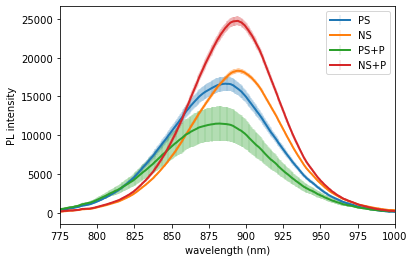

In [7]:
##### PLOTTING SPREADS #####

plt.ylabel('PL intensity')
plt.xlabel('wavelength (nm)')
plt.xlim(775,1000)

samplelist=['PS','NS','PS+P','NS+P']

for p in samplelist:
    plt.errorbar(wav,PLSAdf[p+'_mean'],yerr=PLSAdf[p+'_se'],fmt='-',elinewidth=0.2,lw=2,label=p)

plt.legend()


In [8]:
# ##### CALCULATING URBACH ENERGIES #####
# from scipy.optimize import curve_fit

# samplelist=folderlist
# # samplelist=['P']
# Urb=pd.DataFrame(columns=['Eu'],index=folderlist)
# PLen=1240/wav


# def vRS(x,a,b):
#     return b*x*x*np.exp((a-1)*x/0.026)

# for j in samplelist:
#     PLint=PLSAdf[j+'_mean']*1e12
#     PLen_=[]
#     PLint_=[]
#     for jj in range(len(PLen)):
#         if (PLen[jj] > 1.25 and PLen[jj] < 1.32):
#             PLen_.append(PLen[jj])
#             PLint_.append(PLint[jj])
    
#     plt.semilogy(PLen,PLint,label=j)
    
#     prms,cov=curve_fit(f=vRS,
#                       xdata=PLen_,
#                       ydata=PLint_,
#                       p0=[2,2e-4],
#                       method='dogbox')
    
#     vRSf=[]
#     for jj in range(len(PLen_)):
#         vRSf.append(vRS(PLen_[jj],prms[0],prms[1]))
#     plt.semilogy(PLen_,vRSf,'k--')
    
#     Eu=round(0.026/prms[0]*1000,2)
#     Urb['Eu'][j]=Eu
#     plt.legend()
    
# plt.xlim(1.2,1.5)
# plt.ylim(1e14,2.5e16)

Urb=pd.DataFrame(columns=['Eu'],index=folderlist)
eu=[14.62,17.56,14.57,14.60,13.91,13.35,17.97,13.63,13.72,14.50]
i=0
for e in folderlist:
    Urb['Eu'][e]=eu[i]
    i+=1
display(Urb)

,Eu
C,14.62
C+B,17.56
C+P,14.57
CW,14.6
NS,13.91
NS+P,13.35
P,17.97
P+P,13.63
PS,13.72
PS+P,14.5


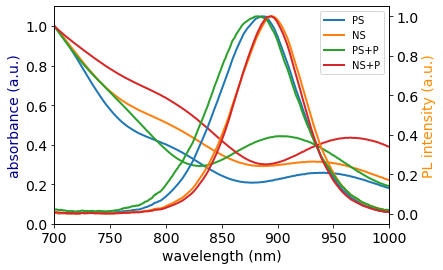

In [9]:
##### PLOTTING UV/vis WITH MEAN PL #####

## loading baseline and control sample UVvis and implenting simple background correction
# ODbase=pd.read_csv(path+'100Tbaseline.csv')

# samplelist=folderlist
# samplelist=['C','C+B','CW','PS+P']

fig,ax=plt.subplots()
ax.set_xlim(700,1000)
ax.set_ylim(0,1.1)
ax.set_xlabel('wavelength (nm)',fontsize=14)
ax.tick_params(labelsize=14)
ax.set_ylabel('absorbance (a.u.)',fontsize=14,c='darkblue')
ax2=ax.twinx()
ax2.set_ylabel('PL intensity (a.u.)',fontsize=14,c='darkorange')
ax2.tick_params(labelsize=14)

for u in samplelist:
    absorb=pd.read_csv(path+'UVvis\\'+u+'.Sample.Raw.csv')
    ax.plot(absorb['nm'],absorb[' A'].div(round(float(absorb[absorb['nm']==700.0][' A']),3)),lw=2,label=u)
    ax2.plot(wav,PLSAdf[u+'_mean']/PLSAdf[u+'_mean'].max(),lw=2)

ax.legend()

In [10]:
# ##### MULTIPLE TAUC PLOT + FIT #####

Egdf=pd.Series(index=folderlist,dtype='float64')

# z = 200e-7 #cm
# alpha=[]
# samplelist=['PS+P']
# wavUVvis = absorb['nm']
# eph = 1240/wavUVvis

# fitmask=[
#     (eph >= 1.5) & ( eph <= 1.55),
# #     (eph >= 1.55) & ( eph <= 1.6)
# #     (eph >= 1.57) & ( eph <= 1.65)
# ]

# # how much of the fit gets plotted
# plotmask=[
#     (eph >= 1.4) & (eph <= 1.65),
# #         (eph >= 1.4) & (eph <= 1.8)
# #     (eph >= 1.45) & (eph <= 1.6),
# #     (eph >= 1.52) & (eph <= 1.7)
# ]

# for i in samplelist:
#     absorb=pd.read_csv(path+'UVvis\\'+i+'.Sample.Raw.csv')
    
#     alpha = (absorb[' A'].mul(2.303)).divide(z);
#     yaxis=(alpha.mul(eph)).pow(2)
#     mask = (eph >= 1.4) & (eph <= 1.6)
    
#     fit = np.polyfit(eph[fitmask[samplelist.index(i)]],yaxis[fitmask[samplelist.index(i)]],1)
#     Eg = -fit[1]/fit[0]   # fit[0] = slope, fit[1] = intercept
#     print(i,'Eg = ', round(Eg,4), 'eV')
# #     Egdf[i]=Eg
    
#     label = i + " Eg = " + str(format(Eg,'.2f')) + " eV"
#     plt.plot(eph[mask],yaxis[mask],label=label)
#     plt.plot(eph[plotmask[samplelist.index(i)]],fit[1]+fit[0]*eph[plotmask[samplelist.index(i)]], 'r--')
#     plt.legend()
#     plt.show()

# plt.xlabel('wavelength (eV)')
# plt.ylabel('(alpha*hv)^2')

# print(Egdf)
# plt.savefig('Eg_1208_summary',dpi=500)


eg=[1.413514,1.498702,1.415864,1.369390,1.405101,1.405110,1.440358,1.414654,1.427097,1.493077]
i=0
for e in folderlist:
    Egdf[e]=eg[i]
    i+=1

Egdf['PS+P','CW','C+B','NS+P']=np.NaN
print(Egdf)

C       1.413514
C+B          NaN
C+P     1.415864
CW           NaN
NS      1.405101
NS+P         NaN
P       1.440358
P+P     1.414654
PS      1.427097
PS+P         NaN
dtype: float64


In [21]:
##### IMPORTING IDPL 
##### & LATTICE CONSTANTS DATA 
##### & 2D GIWAXS DATA 
##### & HC PARAMETERS #####

IDPL=pd.DataFrame(pd.read_csv(path+'idpl_analysis.csv',index_col=0))
display(IDPL)

VolChange=pd.DataFrame(pd.read_csv(path+'lattice_constants.csv',index_col=0))
display(VolChange)

pk_params=pd.DataFrame(pd.read_csv(path+'OOP_pk_params.csv',index_col=0))
display(pk_params)

tc_params=pd.DataFrame(pd.read_csv(path+'TCparams.csv',index_col=0))
display(tc_params)

,delpeak,delinfl
C,8.490322,14.477186
C+B,16.576726,26.264582
C+P,14.151501,3.147694
CW,21.074531,19.476256
NS,10.062315,0.629586
NS+P,21.703131,23.252915
P,16.675375,34.133606
P+P,8.805532,4.092333
PS,16.987831,10.623416
PS+P,17.304825,29.753262


,a,c,vol_change
C,8.80476,12.49660,0.000005
P,8.85654,12.60060,2.021610
NS,8.88221,12.46541,1.513070
PS,8.88221,12.52762,2.019650
C+P,8.85654,12.60060,2.021610
P+P,8.85654,12.66475,2.541030
NS+P,8.85654,12.60060,2.021610
PS+P,8.85654,12.66475,2.541030
C+B,8.83014,12.54964,1.004060
CW,8.88221,12.46541,1.513070


,f,f',pk2_FWHM
C,0.774,0.110,NaN
P,0.846,0.394,69.136
NS,0.733,-0.053,NaN
PS,0.958,0.835,49.953
C+P,0.674,-0.285,NaN
P+P,0.893,0.578,53.337
NS+P,0.669,-0.302,NaN
PS+P,0.923,0.696,54.494
C+B,0.642,-0.411,NaN
CW,0.673,-0.286,NaN


,TC_high,TC_del,TC_low
C,471.491306,34.423918,437.067388
C+B,553.380287,116.780160,436.600127
C+P,439.962120,44.083336,395.878784
CW,522.435627,90.904699,431.530928
NS,444.958817,35.722715,409.236101
NS+P,473.259779,98.627002,374.632777
P,512.551227,20.588649,491.962578
P+P,462.387672,51.499641,410.888031
PS,483.430423,69.012780,414.417644
PS+P,586.405023,113.637945,472.767078


In [22]:
##### PEAK POSITION, FWHM, & SPREAD AT PEAK FROM MEAN PL #####

SUMdf=pd.DataFrame(index=samplelist,columns=['PeakIntensity','PeakPos','PeakPos_SE','FWHM','SE',
                                             'Urb','IDPL_delPeak','IDPL_delInfl','TC_low','TC_high','TC_del','Eg_dev','VolChange',
                                             'pk1_OOP_H','pk2_FWHM'])

samplelist=folderlist
# samplelist=['C','C+P','C+B','CW']
for p in samplelist:
    SUMdf['PeakIntensity'][p]=PLSAdf[p+'_mean'].max()
    SUMdf['PeakPos'][p]=wav[PLSAdf[p+'_mean'].idxmax()]
    SUMdf['PeakPos_SE']=PLSAdf_err['PeakPos']
    SUMdf['FWHM'][p]=wav[round(sp.signal.peak_widths(PLSAdf[p+'_mean'],peaks=[PLSAdf[p+'_mean'].idxmax()])[0][0])]-wav[0]
    SUMdf['SE'][p]=PLSAdf[p+'_se'][PLSAdf[p+'_mean'].idxmax()]*2/PLSAdf[p+'_mean'].max()   # normalized to intensity
    SUMdf['Urb'][p]=Urb['Eu'][p]
    SUMdf['IDPL_delPeak'][p]=IDPL['delpeak'][p]
    SUMdf['IDPL_delInfl'][p]=IDPL['delinfl'][p]
    SUMdf['TC_low'][p]=tc_params['TC_low'][p]
    SUMdf['TC_high'][p]=tc_params['TC_high'][p]
    SUMdf['TC_del'][p]=tc_params['TC_del'][p]
    SUMdf['Eg_dev']=abs(Egdf.sub(1240/SUMdf['PeakPos'])*1000)
    SUMdf['VolChange'][p]=VolChange['vol_change'][p]
    SUMdf['pk1_OOP_H'][p]=pk_params['f'][p]
    SUMdf['pk2_FWHM'][p]=pk_params['pk2_FWHM'][p]

display(SUMdf)


,PeakIntensity,PeakPos,PeakPos_SE,FWHM,SE,Urb,IDPL_delPeak,IDPL_delInfl,TC_low,TC_high,TC_del,Eg_dev,VolChange,pk1_OOP_H,pk2_FWHM
C,18603.932355,889.073563,0.948801,79.918249,0.415969,14.62,8.490322,14.477186,437.067388,471.491306,34.423918,18.803762,0.000005,0.774,NaN
C+B,22888.030015,855.720864,0.822868,88.057409,0.176889,17.56,16.576726,26.264582,436.600127,553.380287,116.78016,NaN,1.00406,0.642,NaN
C+P,14618.928209,893.161262,0.580704,79.292082,0.210137,14.57,14.151501,3.147694,395.878784,439.96212,44.083336,27.536883,2.02161,0.674,NaN
CW,38670.702824,893.161262,0.370311,68.645604,0.135371,14.6,21.074531,19.476256,431.530928,522.435627,90.904699,NaN,1.51307,0.673,NaN
NS,18312.694772,894.418893,0.502118,72.403539,0.034066,13.91,10.062315,0.629586,409.236101,444.958817,35.722715,18.725992,1.51307,0.733,NaN
NS+P,24745.687754,894.104491,0.420309,68.645604,0.047852,13.35,21.703131,23.252915,374.632777,473.259779,98.627002,NaN,2.02161,0.669,NaN
P,7784.373739,882.469075,1.106427,86.179307,0.161533,17.97,16.675375,34.133606,491.962578,512.551227,20.588649,35.20961,2.02161,0.846,69.136
P+P,13671.296383,892.218001,0.412594,71.150937,0.132844,13.63,8.805532,4.092333,410.888031,462.387672,51.499641,24.859131,2.54103,0.893,53.337
PS,16654.847081,886.243261,0.58804,82.735861,0.113367,13.72,16.987831,10.623416,414.417644,483.430423,69.01278,27.932623,2.01965,0.958,49.953
PS+P,11517.913236,881.839995,1.412991,88.057409,0.385895,14.5,17.304825,29.753262,472.767078,586.405023,113.637945,NaN,2.54103,0.923,54.494


## FWHM, PEAK POSITION, STANDARD ERROR AT PEAK

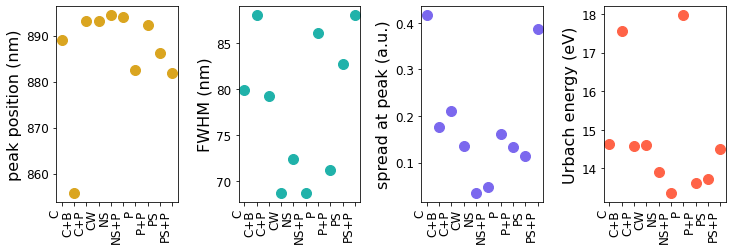

In [89]:

fig,(ax1,ax2,ax3,ax4)=plt.subplots(nrows=1,ncols=4,sharex=True,figsize=(12,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, 
                    wspace=0.5)

ax1.plot(SUMdf['PeakPos'].dropna(),'o',ms=10,c='goldenrod')
# ax1.errorbar(samplelist,SUMdf['PeakPos'].dropna(),yerr=SUMdf['PeakPos_SE'])
ax1.set_ylabel('peak position (nm)',fontsize=16)
ax1.tick_params(labelsize=12)
# ax1.set_ylim(ymin=890,ymax=907)

ax2.plot(SUMdf['FWHM'].dropna(),'o',c='lightseagreen',ms=10)
ax2.set_ylabel('FWHM (nm)',fontsize=16)
ax2.tick_params(labelsize=12)
# ax2.set_ylim(ymin=62,ymax=68)

ax3.plot(SUMdf['SE'].dropna(),'o',c='mediumslateblue',ms=10)
ax3.set_ylabel('spread at peak (a.u.)',fontsize=16)
ax3.tick_params(labelsize=12)
# ax3.set_ylim(ymin=0,ymax=0.8)

ax4.plot(SUMdf['Urb'].dropna(),'o',c='tomato',ms=10)
ax4.set_ylabel('Urbach energy (eV)',fontsize=16)
ax4.tick_params(labelsize=12)

fig.autofmt_xdate(rotation=90)

# fig.savefig('FASnI3\\0502_PEASCN\\'+'HS_all_peaks.png',
#             dpi=500,
#            bbox_inches='tight')


## CORRELATION CHECK

In [52]:
import dataframe_image as dfi

display(SUMdf)
display(SUMdf.astype('float64').corr())

dfi.export(SUMdf.astype('float64').corr(),path+'corr_table.png')

,PeakIntensity,PeakPos,PeakPos_SE,FWHM,SE,Urb,IDPL_delPeak,IDPL_delInfl,TC_low,TC_high,TC_del,Eg_dev,VolChange,pk1_OOP_H,pk2_FWHM
C,18603.932355,889.073563,0.948801,79.918249,0.415969,14.62,8.490322,14.477186,437.067388,471.491306,34.423918,18.803762,0.000005,0.774,NaN
C+B,22888.030015,855.720864,0.822868,88.057409,0.176889,17.56,16.576726,26.264582,436.600127,553.380287,116.78016,NaN,1.00406,0.642,NaN
C+P,14618.928209,893.161262,0.580704,79.292082,0.210137,14.57,14.151501,3.147694,395.878784,439.96212,44.083336,27.536883,2.02161,0.674,NaN
CW,38670.702824,893.161262,0.370311,68.645604,0.135371,14.6,21.074531,19.476256,431.530928,522.435627,90.904699,NaN,1.51307,0.673,NaN
NS,18312.694772,894.418893,0.502118,72.403539,0.034066,13.91,10.062315,0.629586,409.236101,444.958817,35.722715,18.725992,1.51307,0.733,NaN
NS+P,24745.687754,894.104491,0.420309,68.645604,0.047852,13.35,21.703131,23.252915,374.632777,473.259779,98.627002,NaN,2.02161,0.669,NaN
P,7784.373739,882.469075,1.106427,86.179307,0.161533,17.97,16.675375,34.133606,491.962578,512.551227,20.588649,35.20961,2.02161,0.846,69.136
P+P,13671.296383,892.218001,0.412594,71.150937,0.132844,13.63,8.805532,4.092333,410.888031,462.387672,51.499641,24.859131,2.54103,0.893,53.337
PS,16654.847081,886.243261,0.58804,82.735861,0.113367,13.72,16.987831,10.623416,414.417644,483.430423,69.01278,27.932623,2.01965,0.958,49.953
PS+P,11517.913236,881.839995,1.412991,88.057409,0.385895,14.5,17.304825,29.753262,472.767078,586.405023,113.637945,NaN,2.54103,0.923,54.494


,PeakIntensity,PeakPos,PeakPos_SE,FWHM,SE,Urb,IDPL_delPeak,IDPL_delInfl,TC_low,TC_high,TC_del,Eg_dev,VolChange,pk1_OOP_H,pk2_FWHM
PeakIntensity,1.000000,0.075869,-0.560961,-0.563870,-0.272005,-0.194340,0.452996,-0.012308,-0.363069,0.066471,0.449737,-0.896180,-0.340441,-0.612144,-0.929957
PeakPos,0.075869,1.000000,-0.447560,-0.721170,-0.199820,-0.731793,-0.143381,-0.522623,-0.420933,-0.651645,-0.467043,-0.704088,0.229158,0.101351,-0.471587
PeakPos_SE,-0.560961,-0.447560,1.000000,0.830013,0.740853,0.496482,-0.025245,0.633239,0.816924,0.654986,0.079397,0.384296,-0.037076,0.397127,0.440691
FWHM,-0.563870,-0.721170,0.830013,1.000000,0.541131,0.647430,-0.005494,0.492704,0.678236,0.574604,0.107716,0.673349,-0.061739,0.340191,0.363118
SE,-0.272005,-0.199820,0.740853,0.541131,1.000000,0.150730,-0.257616,0.276588,0.511774,0.407047,0.045291,-0.206530,-0.330066,0.244460,-0.024167
Urb,-0.194340,-0.731793,0.496482,0.647430,0.150730,1.000000,0.128615,0.624064,0.686642,0.472941,-0.038510,0.696013,-0.227668,-0.168848,0.983152
IDPL_delPeak,0.452996,-0.143381,-0.025245,-0.005494,-0.257616,0.128615,1.000000,0.608330,0.019097,0.480203,0.632457,0.825136,0.291505,-0.229179,0.221895
IDPL_delInfl,-0.012308,-0.522623,0.633239,0.492704,0.276588,0.624064,0.608330,1.000000,0.660885,0.800547,0.431378,0.670373,0.017415,0.029436,0.731078
TC_low,-0.363069,-0.420933,0.816924,0.678236,0.511774,0.686642,0.019097,0.660885,1.000000,0.677684,-0.071127,0.553021,-0.026870,0.400320,0.806989
TC_high,0.066471,-0.651645,0.654986,0.574604,0.407047,0.472941,0.480203,0.800547,0.677684,1.000000,0.685289,0.656905,0.091895,0.161984,0.146606


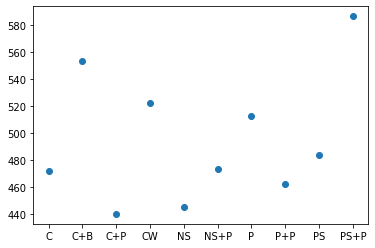

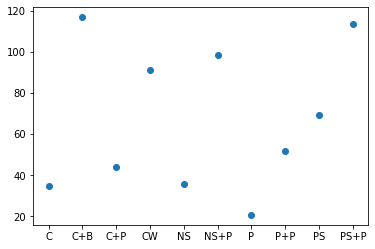

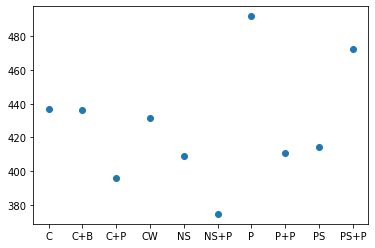

In [24]:
plt.scatter(x=folderlist,y=SUMdf['TC_high'])
plt.show()
plt.scatter(x=folderlist,y=SUMdf['TC_del'])
plt.show()
plt.scatter(x=folderlist,y=SUMdf['TC_low'])

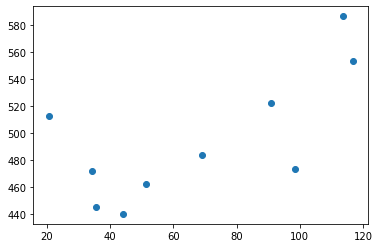

886.2410666156269


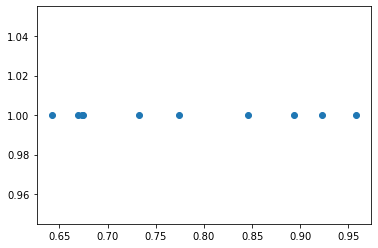

In [19]:
plt.scatter(SUMdf['TC_del'],SUMdf['TC_high'])
plt.show()
plt.scatter(SUMdf['pk1_OOP_H'],[1,1,1,1,1,1,1,1,1,1])
print(SUMdf['PeakPos'].mean())

,PeakIntensity,PeakPos,FWHM,SE,Urb,TC_high,TC_del,VolChange,pk1_OOP_H
c,18603.932355,889.073563,79.918249,0.415969,14.62,471.491306,34.423918,0.000005,0.774
p,13019.383009,887.291199,82.73575,0.161679,15.42,478.647923,44.561588,2.020957,0.826
2p,12594.604809,887.028998,79.604173,0.259369,14.065,524.396348,82.568793,2.54103,0.908
s,17807.785711,889.15166,77.960603,0.145295,13.87,497.013511,79.250111,2.02384,0.82075
p_bulk,12407.107609,885.692583,82.030879,0.19841,14.955,511.193586,63.684754,2.28083,0.905
p_surf,16138.456395,890.330937,76.786508,0.194182,14.0125,490.503649,76.961981,2.28132,0.78975


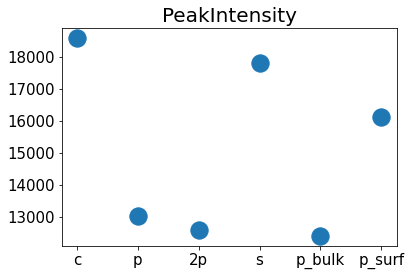

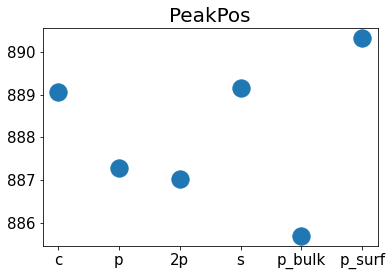

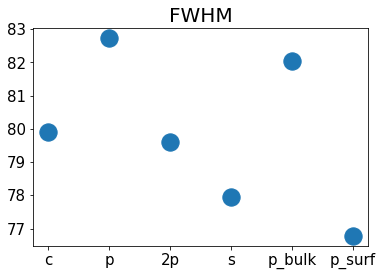

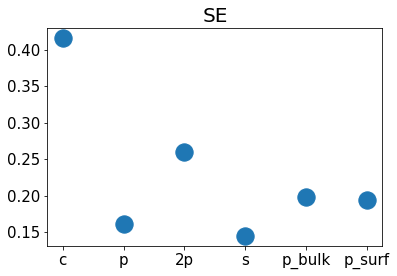

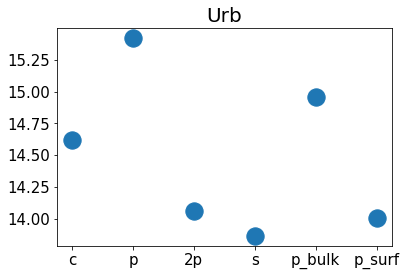

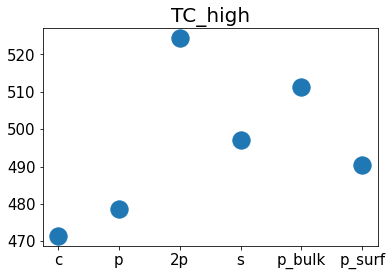

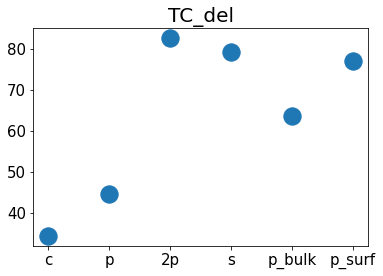

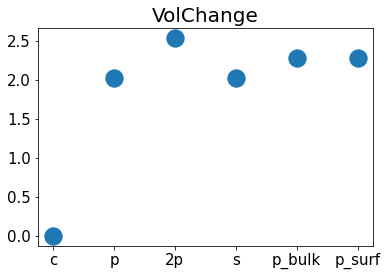

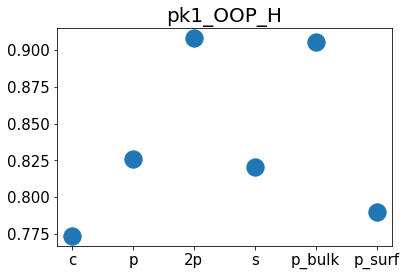

In [51]:
##### AVERAGES OF MATERIAL GROUPS #####

index=['c','p','2p','s','p_bulk','p_surf']
AVGdf=pd.DataFrame(index=index,columns=['PeakIntensity','PeakPos','FWHM','SE',
                                             'Urb','TC_high','TC_del','VolChange','pk1_OOP_H'])
adict={}
adict['c']=['C']
adict['p']=['C+P','P','PS']
adict['s']=['NS','PS','NS+P','PS+P']
adict['p_bulk']=['P','PS','P+P','PS+P']
adict['p_surf']=['C+P','P+P','PS+P','NS+P']
adict['2p']=['P+P','PS+P']

for y in AVGdf:
    for x in index:
        list=[]
        for xx in adict[x]:
            list.append(SUMdf[y][xx])
        AVGdf[y][x]=sum(list)/len(list)
display(AVGdf)

for y in AVGdf:
    plt.scatter(index,AVGdf[y],s=300)
    plt.tick_params(labelsize=15)
    plt.title(y,fontsize=20)
    plt.show()


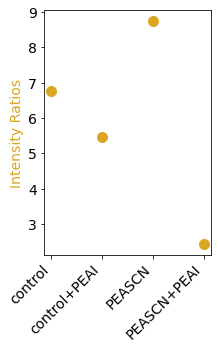

In [45]:
##### HALF STACKS INTENSITY RATIOS #####

n=['HS_C_','HS_CP_','HS_P_','HS_PP_']
nn=['control','control+PEAI','PEASCN','PEASCN+PEAI']
HSratio=[]
for i in n:
    HSratio.append(round(HSAdf[i+'bmean'].max()/HSAdf[i+'fmean'].max(),2))

HSint=[]
for j in n:
    HSint.append(round(HSAdf[j+'bmean'].max()/HSAdf['HS_C_bmean'].max(),2))

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(3,5))
plt.plot(nn,HSratio,'o',ms=10,c='goldenrod')
ax.set_ylabel('Intensity Ratios',fontsize=14,c='goldenrod')
ax.tick_params(labelsize=14)
fig.autofmt_xdate(rotation=45)

# ax1=ax.twinx()
# ax1.plot(n,HSint,'o',c='lightseagreen',ms=10)
# ax1.set_ylabel('Relative PL Intensity',c='lightseagreen',fontsize=14)
# ax1.tick_params(labelsize=14)

# fig.savefig('FASnI3\\0502_PEASCN\\'+'HS_intensityratios.png',dpi=300,bbox_inches='tight')